# Sentiment Analysis in Python

# Step 0. Importing  and reading of data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk


# nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
# nltk.download('punkt')

# nltk.download('vader_lexicon')

# nltk.download('words')

# nltk.download('all')

In [4]:
# Read in data
df = pd.read_csv('test1.csv')
print(df.shape)
# df = df.head(500)
# print(df.shape)

(3534, 9)


In [5]:
df=df.head(10)
df

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km�),Density (P/Km�)
0,f87dea47db,Last session of the day,neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,96d74cb729,Shanghai is also really exciting.,positive,noon,21-30,Albania,2877797,27400.0,105
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044,2381740.0,18
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265,470.0,164
4,33987a8ee5,I like it!!,positive,noon,60-70,Angola,32866272,1246700.0,26
5,726e501993,that`s great!! weee!! visitors!,positive,night,70-100,Antigua and Barbuda,97929,440.0,223
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol,negative,morning,0-20,Argentina,45195774,2736690.0,17
7,afa11da83f,"soooooo wish i could, but im in school and my...",negative,noon,21-30,Armenia,2963243,28470.0,104
8,e64208b4ef,and within a short time of the last clue all ...,neutral,night,31-45,Australia,25499884,7682300.0,3
9,37bcad24ca,What did you get? My day is alright.. haven`...,neutral,morning,46-60,Austria,9006398,82400.0,109


# Model 1. Import VADER Sentiment Analyser

In [6]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

# Model 2. Import Roberta Pretrained Model

In [7]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

## Handling data

In [8]:

sia = SentimentIntensityAnalyzer()

def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict


vaderdf = {}
robertadf = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['text']
        myid = row['textID']
        myid = i+1
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        vaderdf[myid]=vader_result_rename
        robertadf[myid] = polarity_scores_roberta(text)
    except RuntimeError:
        print('RunTimeError')
    except AttributeError:
        print('AttributeError')

  0%|          | 0/10 [00:00<?, ?it/s]

## Vader dataframe with graph

In [9]:
# Define a mapping from column names to sentiment labels
sentiment_mapping1 = {
    'vader_neg': 'negative',
    'vader_neu': 'neutral',
    'vader_pos': 'positive'
}


results_df1 = pd.DataFrame(vaderdf).T
results_df1['index']=results_df1.index
# Use idxmax to find the column with the maximum value, then map it to the corresponding sentiment label
results_df1['max_sentiment'] = results_df1[['vader_neg', 'vader_neu', 'vader_pos']].idxmax(axis=1).apply(lambda col_name: sentiment_mapping1[col_name])

results_df1

,vader_neg,vader_neu,vader_pos,vader_compound,index,max_sentiment
1,0.000,1.000,0.000,0.0000,1,neutral
2,0.000,0.534,0.466,0.5413,2,neutral
3,0.382,0.618,0.000,-0.7345,3,neutral
4,0.000,0.200,0.800,0.6114,4,positive
5,0.000,0.245,0.755,0.4738,5,positive
6,0.000,0.363,0.637,0.7405,6,positive
7,0.318,0.437,0.245,-0.2103,7,neutral
8,0.207,0.669,0.124,-0.3048,8,neutral
9,0.000,1.000,0.000,0.0000,9,neutral
10,0.000,1.000,0.000,0.0000,10,neutral


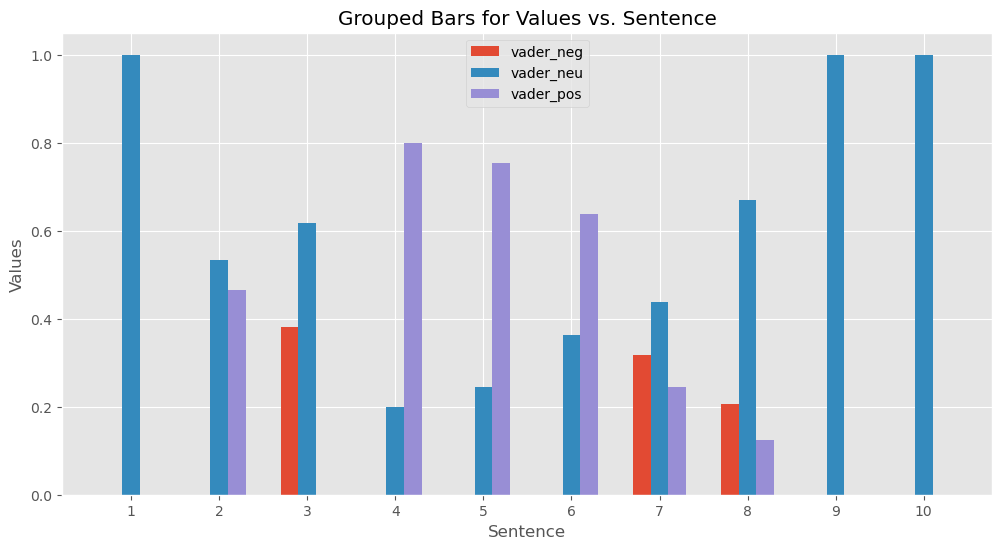

In [10]:
fig, ax = plt.subplots(figsize=(12, 6)) 

# Set the width of each bar
bar_width = 0.2

# Set the positions for the bars
bar_positions = np.arange(len(results_df1.index))

# Create grouped bars
plt.bar(bar_positions - bar_width, results_df1['vader_neg'], width=bar_width, label='vader_neg')
plt.bar(bar_positions, results_df1['vader_neu'], width=bar_width, label='vader_neu')
plt.bar(bar_positions + bar_width, results_df1['vader_pos'], width=bar_width, label='vader_pos')

# Set labels and title
plt.xlabel('Sentence')
plt.ylabel('Values')
plt.title('Grouped Bars for Values vs. Sentence')
plt.xticks(bar_positions, results_df1.index)

# Adjust legend and show the plot
plt.legend()
plt.show()

## RoBerta dataframe with graph

In [11]:
# Define a mapping from column names to sentiment labels
sentiment_mapping3 = {
    'roberta_neg': 'negative',
    'roberta_neu': 'neutral',
    'roberta_pos': 'positive'
}

results_df3 = pd.DataFrame(robertadf).T
results_df3['index']=results_df3.index
# Use idxmax to find the column with the maximum value, then map it to the corresponding sentiment label
results_df3['max_sentiment'] = results_df3[['roberta_neg', 'roberta_neu', 'roberta_pos']].idxmax(axis=1).apply(lambda col_name: sentiment_mapping3[col_name])

results_df3

,roberta_neg,roberta_neu,roberta_pos,index,max_sentiment
1,0.053005,0.836854,0.110141,1,neutral
2,0.001310,0.017418,0.981272,2,positive
3,0.908455,0.084444,0.007101,3,negative
4,0.002410,0.013607,0.983983,4,positive
5,0.002323,0.019952,0.977724,5,positive
6,0.001562,0.007538,0.990900,6,positive
7,0.948958,0.043306,0.007736,7,negative
8,0.857621,0.127331,0.015048,8,negative
9,0.203005,0.742505,0.054490,9,neutral
10,0.005656,0.167485,0.826859,10,positive


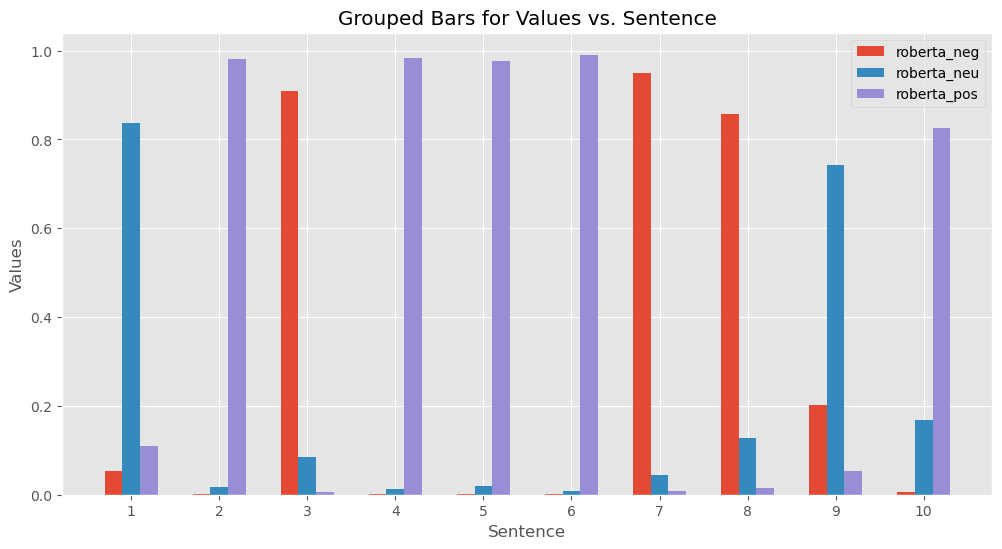

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

# Set the width of each bar
bar_width = 0.2

# Set the positions for the bars
bar_positions = np.arange(len(results_df3.index))


# Create grouped bars
plt.bar(bar_positions - bar_width, results_df3['roberta_neg'], width=bar_width, label='roberta_neg')
plt.bar(bar_positions, results_df3['roberta_neu'], width=bar_width, label='roberta_neu')
plt.bar(bar_positions + bar_width, results_df3['roberta_pos'], width=bar_width, label='roberta_pos')

# Set labels and title
plt.xlabel('Sentence')
plt.ylabel('Values')
plt.title('Grouped Bars for Values vs. Sentence')
plt.xticks(bar_positions, results_df3.index)

# Adjust legend and show the plot
plt.legend()
plt.show()

## Comparing each negative dataframe

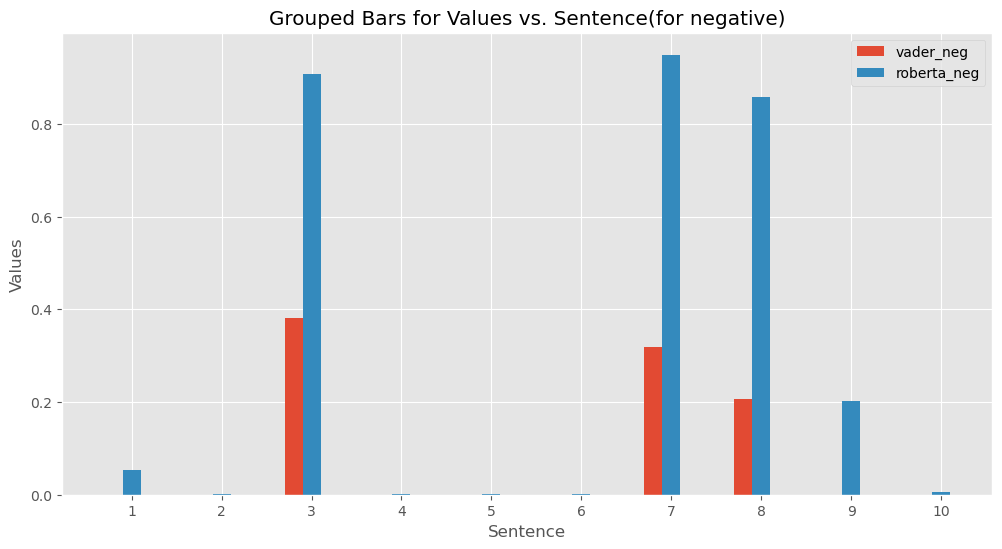

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))

# Set the width of each bar
bar_width = 0.2

# Set the positions for the bars
bar_positions = np.arange(len(results_df1.index))


# Create grouped bars
plt.bar(bar_positions - bar_width, results_df1['vader_neg'], width=bar_width, label='vader_neg')
plt.bar(bar_positions, results_df3['roberta_neg'], width=bar_width, label='roberta_neg')

# Set labels and title
plt.xlabel('Sentence')
plt.ylabel('Values')
plt.title('Grouped Bars for Values vs. Sentence(for negative)')
plt.xticks(bar_positions, results_df1.index)

# Adjust legend and show the plot
plt.legend()
plt.show()

## Comparing each neutral dataframe

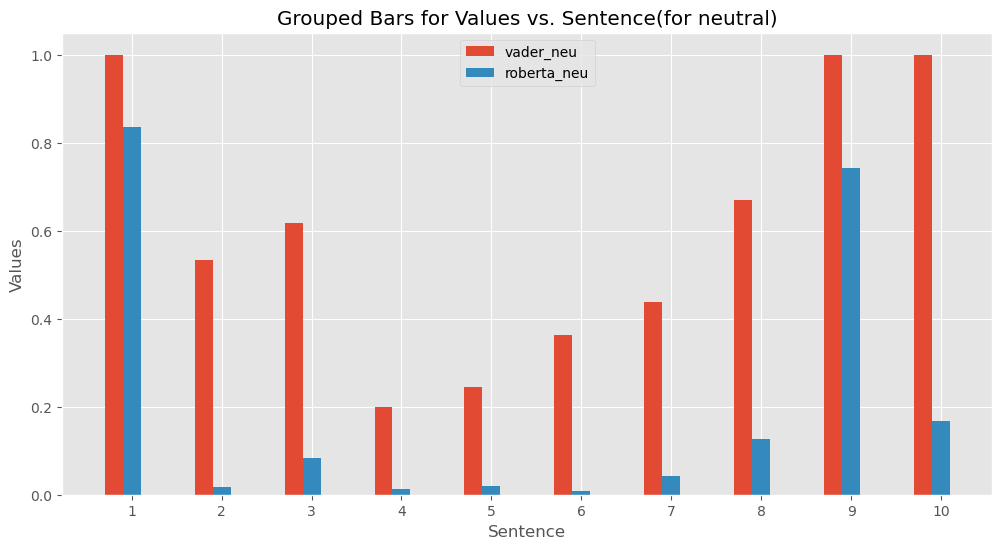

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

# Set the width of each bar
bar_width = 0.2

# Set the positions for the bars
bar_positions = np.arange(len(results_df1.index))


# Create grouped bars
plt.bar(bar_positions - bar_width, results_df1['vader_neu'], width=bar_width, label='vader_neu')
plt.bar(bar_positions, results_df3['roberta_neu'], width=bar_width, label='roberta_neu')

# Set labels and title
plt.xlabel('Sentence')
plt.ylabel('Values')
plt.title('Grouped Bars for Values vs. Sentence(for neutral)')
plt.xticks(bar_positions, results_df1.index)

# Adjust legend and show the plot
plt.legend()
plt.show()

## Comparing each positive dataframe

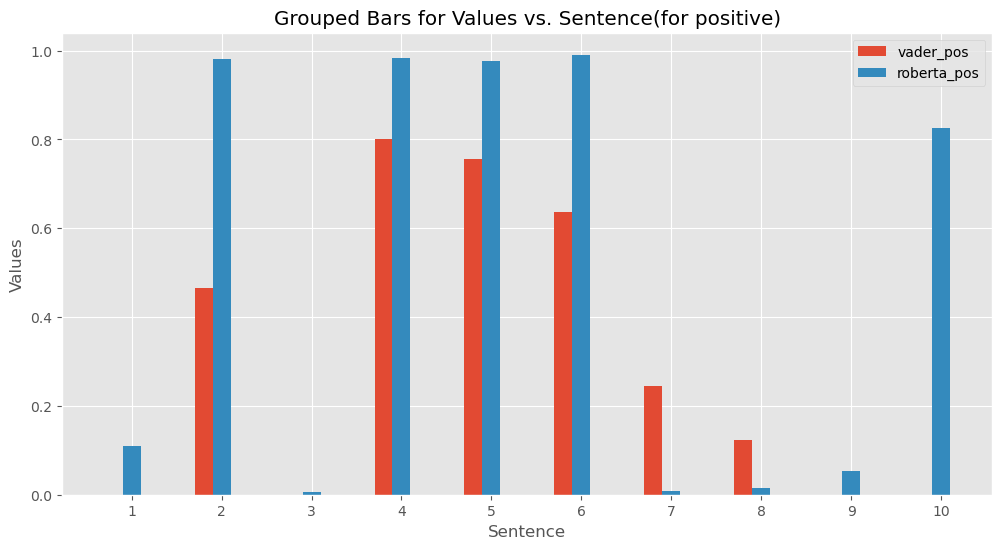

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

# Set the width of each bar
bar_width = 0.2

# Set the positions for the bars
bar_positions = np.arange(len(results_df1.index))


# Create grouped bars
plt.bar(bar_positions - bar_width, results_df1['vader_pos'], width=bar_width, label='vader_pos')
plt.bar(bar_positions, results_df3['roberta_pos'], width=bar_width, label='roberta_pos')

# Set labels and title
plt.xlabel('Sentence')
plt.ylabel('Values')
plt.title('Grouped Bars for Values vs. Sentence(for positive)')
plt.xticks(bar_positions, results_df1.index)

# Adjust legend and show the plot
plt.legend()
plt.show()

In [16]:
df_original=df
df_modified=results_df1

# Create a labeled dataset
labeled_dataset = pd.merge(df_original, df_modified, left_index=True, right_on="index")
labeled_dataset = labeled_dataset[["text", "sentiment", "max_sentiment"]]
labeled_dataset

,text,sentiment,max_sentiment
1,Shanghai is also really exciting.,positive,neutral
2,"Recession hit Veronique Branquinho, she has to...",negative,neutral
3,happy bday!,positive,neutral
4,I like it!!,positive,positive
5,that`s great!! weee!! visitors!,positive,positive
6,I THINK EVERYONE HATES ME ON HERE lol,negative,positive
7,"soooooo wish i could, but im in school and my...",negative,neutral
8,and within a short time of the last clue all ...,neutral,neutral
9,What did you get? My day is alright.. haven`...,neutral,neutral


In [17]:
# Compare the predicted sentiment with the true sentiment
correct_predictions = (labeled_dataset["sentiment"] == labeled_dataset["max_sentiment"]).sum()
total_predictions = len(labeled_dataset)
accuracy = correct_predictions / total_predictions

print("Accuracy:", accuracy)

Accuracy: 0.4444444444444444


In [18]:
# Compare the predicted sentiment with the true sentiment
correct_predictions = (labeled_dataset["sentiment"] == labeled_dataset["max_sentiment"]).sum()
total_predictions = len(labeled_dataset)
accuracy = correct_predictions / total_predictions

print("Accuracy:", accuracy)

Accuracy: 0.4444444444444444


In [19]:
df_original=df
df_modified=results_df3

# Create a labeled dataset
labeled_dataset = pd.merge(df_original, df_modified, left_index=True, right_on="index")
labeled_dataset = labeled_dataset[["text", "sentiment", "max_sentiment"]]
labeled_dataset

,text,sentiment,max_sentiment
1,Shanghai is also really exciting.,positive,neutral
2,"Recession hit Veronique Branquinho, she has to...",negative,positive
3,happy bday!,positive,negative
4,I like it!!,positive,positive
5,that`s great!! weee!! visitors!,positive,positive
6,I THINK EVERYONE HATES ME ON HERE lol,negative,positive
7,"soooooo wish i could, but im in school and my...",negative,negative
8,and within a short time of the last clue all ...,neutral,negative
9,What did you get? My day is alright.. haven`...,neutral,neutral


In [20]:
# Compare the predicted sentiment with the true sentiment
correct_predictions = (labeled_dataset["sentiment"] == labeled_dataset["max_sentiment"]).sum()
total_predictions = len(labeled_dataset)
accuracy = correct_predictions / total_predictions

print("Accuracy:", accuracy)

Accuracy: 0.4444444444444444
